- Guzmán Pérez Karla Isela
- Velasco Avila Cristopher

# Ejercicio 3: Predicción de consumo excesivo de agua en manzanas de la CDMX
## Descripción: 
De acuerdo con los datos públicos de consumo de agua en la Ciudad de México, predece si
una manzana (unidad geográfica censal) presentará un consumo excesivo de agua en un
próximo periodo bimestral.

In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import pyarrow

## Carga y exploración general de los datos


Importamos el dataset y a su vez, omitimos los valores nulos y se sustituyen con "NA" para evitar problemas en el análisis posterior.

In [3]:
data = pl.read_csv("consumo_agua_historico_2019.csv", null_values="NA")
data

fecha_referencia,anio,bimestre,consumo_total_mixto,consumo_prom_dom,consumo_total_dom,consumo_prom_mixto,consumo_total,consumo_prom,consumo_prom_no_dom,consumo_total_no_dom,indice_des,colonia,alcaldia,latitud,longitud
str,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,f64,f64
"""2019-06-30""",2019,3,159.72,42.566364,468.23,53.24,631.0,42.066667,3.05,3.05,"""ALTO""","""7 DE NOVIEMBRE""","""GUSTAVO A. MADERO""",19.45526,-99.112662
"""2019-06-30""",2019,3,0.0,35.936667,107.81,0.0,115.13,28.7825,7.32,7.32,"""MEDIO""","""7 DE NOVIEMBRE""","""GUSTAVO A. MADERO""",19.45526,-99.112662
"""2019-06-30""",2019,3,0.0,24.586,122.93,0.0,197.96,32.993333,75.03,75.03,"""POPULAR""","""7 DE NOVIEMBRE""","""GUSTAVO A. MADERO""",19.45572,-99.113582
"""2019-06-30""",2019,3,0.0,0.0,0.0,0.0,253.53,84.51,84.51,253.53,"""BAJO""","""GERTRUDIS SANCHEZ 3A SECCION""","""GUSTAVO A. MADERO""",19.459647,-99.104469
"""2019-06-30""",2019,3,56.72,67.43625,539.49,56.72,839.35,76.304545,121.57,243.14,"""BAJO""","""PRO HOGAR I""","""AZCAPOTZALCO""",19.474161,-99.14675
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2019-02-28""",2019,1,null,20.053112,3930.41,null,4286.28,19.307568,13.687308,355.87,"""BAJO""","""GUERRERO I""","""CUAUHTEMOC""",19.448564,-99.13994
"""2019-02-28""",2019,1,71.3,21.126615,9549.24,35.650001,9796.12,20.976702,13.506923,175.59,"""POPULAR""","""GUERRERO I""","""CUAUHTEMOC""",19.449339,-99.145719
"""2019-02-28""",2019,1,759.16,27.527778,4707.25,94.894999,5692.81,29.344381,15.093334,226.4,"""BAJO""","""GUERRERO I""","""CUAUHTEMOC""",19.448392,-99.14593


Los datos se importan desde un archivo CSV y se realiza un análisis inicial para entender la estructura del dataset, los tipos de variables, la presencia de valores nulos y algunas estadísticas descriptivas básicas.

In [4]:
# Mostrar tipos de datos de cada columna
columns = data.columns
columns

['fecha_referencia',
 'anio',
 'bimestre',
 'consumo_total_mixto',
 'consumo_prom_dom',
 'consumo_total_dom',
 'consumo_prom_mixto',
 'consumo_total',
 'consumo_prom',
 'consumo_prom_no_dom',
 'consumo_total_no_dom',
 'indice_des',
 'colonia',
 'alcaldia',
 'latitud',
 'longitud']

Podemos apreciar que los tipos de dato son solo enteros y flotantes. Esto facilita mucho el analisis de los datos.

In [5]:
# Cantidad de valores nulos por columna
nulos = data.null_count()
nulos

fecha_referencia,anio,bimestre,consumo_total_mixto,consumo_prom_dom,consumo_total_dom,consumo_prom_mixto,consumo_total,consumo_prom,consumo_prom_no_dom,consumo_total_no_dom,indice_des,colonia,alcaldia,latitud,longitud
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,8327,4820,4820,8327,0,0,0,0,0,216,216,0,0


Hay muchos valores nulos que se van a tener que tratar mas adelante.

In [6]:
estadisticas = data.describe()
estadisticas

statistic,fecha_referencia,anio,bimestre,consumo_total_mixto,consumo_prom_dom,consumo_total_dom,consumo_prom_mixto,consumo_total,consumo_prom,consumo_prom_no_dom,consumo_total_no_dom,indice_des,colonia,alcaldia,latitud,longitud
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,f64,f64
"""count""","""71102""",71102.0,71102.0,62775.0,66282.0,66282.0,62775.0,71102.0,71102.0,71102.0,71102.0,"""71102""","""70886""","""70886""",71102.0,71102.0
"""null_count""","""0""",0.0,0.0,8327.0,4820.0,4820.0,8327.0,0.0,0.0,0.0,0.0,"""0""","""216""","""216""",0.0,0.0
"""mean""",null,2019.0,2.006807,174.359929,29.132386,1186.263611,50.636234,1695.847222,111.217399,126.760172,436.060309,null,null,null,19.392273,-99.132896
"""std""",null,0.0,0.814393,312.663596,64.565925,2771.038307,130.408673,3555.697457,1069.949262,1095.817805,2126.152162,null,null,null,0.070549,0.05789
"""min""","""2019-02-28""",2019.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""ALTO""","""10 DE ABRIL""","""ALVARO OBREGON""",19.135867,-99.337703
"""25%""",null,2019.0,1.0,0.0,18.690313,161.63,0.0,340.95,23.01,6.275,10.98,null,null,null,19.344073,-99.172484
"""50%""",null,2019.0,2.0,79.94,26.414286,604.23,33.451667,896.21,31.694,19.280001,54.07,null,null,null,19.39291,-99.135196
"""75%""",null,2019.0,3.0,233.33,36.246667,1261.45,61.221667,1808.94,45.485,54.19,230.44,null,null,null,19.446822,-99.09663
"""max""","""2019-06-30""",2019.0,3.0,23404.44,7796.41,95060.69,11702.22,119726.94,89691.773438,89691.773438,119726.94,"""POPULAR""","""ZOTOLTITLA""","""XOCHIMILCO""",19.579103,-98.950469


Podemos observar que existen muchas caracteristicas en el dataset que se van a tener que tratar, como por ejemplo, los nombres de las colonias y delegaciones indicadas como texto en vez de un codigo, los tipos de datos inconsistentes, y cierta cantidad de valores nulos.

## Limpieza básica.


Eliminando columnas que no se usaran. Esto es debido a que dichos valores no aportan información relevante para el analisis o se pueden usar otras columnas para obtener la misma información.

In [8]:
data_clean = data.drop(["consumo_total", 
                        "consumo_total_dom", 
                        "consumo_total_no_dom", 
                        "consumo_prom_no_dom", 
                        "consumo_total_mixto", 
                        "consumo_prom_mixto", 
                        "indice_des", 
                        "fecha_referencia"])

print(data_clean)

data_clean.describe()

shape: (71_102, 8)
┌──────┬──────────┬─────────────┬─────────────┬─────────────┬─────────────┬───────────┬────────────┐
│ anio ┆ bimestre ┆ consumo_pro ┆ consumo_pro ┆ colonia     ┆ alcaldia    ┆ latitud   ┆ longitud   │
│ ---  ┆ ---      ┆ m_dom       ┆ m           ┆ ---         ┆ ---         ┆ ---       ┆ ---        │
│ i64  ┆ i64      ┆ ---         ┆ ---         ┆ str         ┆ str         ┆ f64       ┆ f64        │
│      ┆          ┆ f64         ┆ f64         ┆             ┆             ┆           ┆            │
╞══════╪══════════╪═════════════╪═════════════╪═════════════╪═════════════╪═══════════╪════════════╡
│ 2019 ┆ 3        ┆ 42.566364   ┆ 42.066667   ┆ 7 DE        ┆ GUSTAVO A.  ┆ 19.45526  ┆ -99.112662 │
│      ┆          ┆             ┆             ┆ NOVIEMBRE   ┆ MADERO      ┆           ┆            │
│ 2019 ┆ 3        ┆ 35.936667   ┆ 28.7825     ┆ 7 DE        ┆ GUSTAVO A.  ┆ 19.45526  ┆ -99.112662 │
│      ┆          ┆             ┆             ┆ NOVIEMBRE   ┆ MADERO    

statistic,anio,bimestre,consumo_prom_dom,consumo_prom,colonia,alcaldia,latitud,longitud
str,f64,f64,f64,f64,str,str,f64,f64
"""count""",71102.0,71102.0,66282.0,71102.0,"""70886""","""70886""",71102.0,71102.0
"""null_count""",0.0,0.0,4820.0,0.0,"""216""","""216""",0.0,0.0
"""mean""",2019.0,2.006807,29.132386,111.217399,null,null,19.392273,-99.132896
"""std""",0.0,0.814393,64.565925,1069.949262,null,null,0.070549,0.05789
"""min""",2019.0,1.0,0.0,0.0,"""10 DE ABRIL""","""ALVARO OBREGON""",19.135867,-99.337703
"""25%""",2019.0,1.0,18.690313,23.01,null,null,19.344073,-99.172484
"""50%""",2019.0,2.0,26.414286,31.694,null,null,19.39291,-99.135196
"""75%""",2019.0,3.0,36.246667,45.485,null,null,19.446822,-99.09663
"""max""",2019.0,3.0,7796.41,89691.773438,"""ZOTOLTITLA""","""XOCHIMILCO""",19.579103,-98.950469


Despues del paso anterior nos hemos deshecho de varias columnas que unicamente aportan información secundaria.

In [12]:
# Eliminar filas con valores nulos
data_clean = data_clean.drop_nulls()
print(data_clean.describe())

print(data_clean.head())

shape: (9, 9)
┌────────────┬─────────┬──────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ statistic  ┆ anio    ┆ bimestre ┆ consumo_pr ┆ … ┆ colonia   ┆ alcaldia  ┆ latitud   ┆ longitud  │
│ ---        ┆ ---     ┆ ---      ┆ om_dom     ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ str        ┆ f64     ┆ f64      ┆ ---        ┆   ┆ str       ┆ str       ┆ f64       ┆ f64       │
│            ┆         ┆          ┆ f64        ┆   ┆           ┆           ┆           ┆           │
╞════════════╪═════════╪══════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ count      ┆ 66085.0 ┆ 66085.0  ┆ 66085.0    ┆ … ┆ 66085     ┆ 66085     ┆ 66085.0   ┆ 66085.0   │
│ null_count ┆ 0.0     ┆ 0.0      ┆ 0.0        ┆ … ┆ 0         ┆ 0         ┆ 0.0       ┆ 0.0       │
│ mean       ┆ 2019.0  ┆ 2.079973 ┆ 29.087137  ┆ … ┆ null      ┆ null      ┆ 19.39433  ┆ -99.13420 │
│            ┆         ┆          ┆            ┆   ┆           ┆           ┆ 

A partir de aqui tenemos un dataset mas limpio y manejable, no tenemos valores nulos y nos hemos quedado unicamente con las columnas que indican un valor importante para el analisis posterior.

3. Análisis exploratorio + visualización inicial
Realiza un análisis estadístico descriptivo y gráficos que muestren patrones o
relaciones importantes.


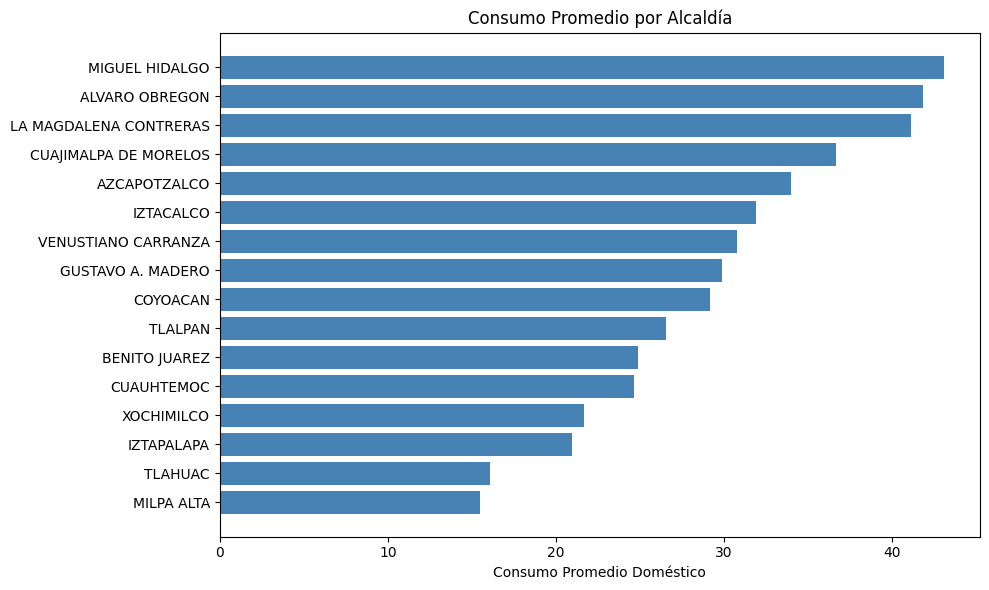

In [10]:
alcaldia_avg = data_clean.group_by("alcaldia").agg(
    pl.col("consumo_prom_dom").mean().alias("prom_consumo_domestico")
)

df_plot = alcaldia_avg.sort("prom_consumo_domestico", descending=True).to_pandas()

plt.figure(figsize=(10, 6))
plt.barh(df_plot["alcaldia"], df_plot["prom_consumo_domestico"], color="steelblue")
plt.xlabel("Consumo Promedio Doméstico")
plt.title("Consumo Promedio por Alcaldía")
plt.gca().invert_yaxis()  # Para que el mayor esté arriba
plt.tight_layout()
plt.show()


En esta grafica podemos observar el consumo promedio de cada alcaldia. Para poder determinar si existe un consumo excesivo, se ha decidido utilizar un valor de percentil de 75% como referencia. Esto significa que cualquier alcaldia que consuma mas del 75% del consumo promedio se considera un consumo excesivo.

## Preprocesamiento técnico


Para obtener el percentil 75 de la columna "consumo_prom_dom", se utiliza la función `quantile` de Polars. Esta función permite calcular percentiles de manera eficiente y flexible.

In [ ]:
# Obteniendo percentil-75 de la columna "consumo_prom_dom"
q3 = data_clean.select(
    pl.col("consumo_prom_dom").quantile(0.75, interpolation="nearest")
)

# Extraer el valor escalar del percentil 75
q3_value = q3.item()

print(q3_value)

data_full = data_clean.with_columns(
    pl.when(pl.col("consumo_prom_dom") > q3_value)
    .then(1)
    .otherwise(0)
    .alias("exceso_consumo_domestico")
)

data_full.head()

36.2699998319


anio,bimestre,consumo_prom_dom,consumo_prom,colonia,alcaldia,latitud,longitud,exceso_consumo_domestico
i64,i64,f64,f64,str,str,f64,f64,i32
2019,3,42.566364,42.066667,"""7 DE NOVIEMBRE""","""GUSTAVO A. MADERO""",19.45526,-99.112662,1
2019,3,35.936667,28.7825,"""7 DE NOVIEMBRE""","""GUSTAVO A. MADERO""",19.45526,-99.112662,0
2019,3,24.586,32.993333,"""7 DE NOVIEMBRE""","""GUSTAVO A. MADERO""",19.45572,-99.113582,0
2019,3,0.0,84.51,"""GERTRUDIS SANCHEZ 3A SECCION""","""GUSTAVO A. MADERO""",19.459647,-99.104469,0
2019,3,67.43625,76.304545,"""PRO HOGAR I""","""AZCAPOTZALCO""",19.474161,-99.14675,1


Hemos comparado el percentil calculado con el consumo promedio de cada colonia y zona, y asi se determina si el consumo es excesivo o no.

Antes de pasar los datos al modelo, debemos codificar las columnas de texto a valores numericos. Esto se hace para que el modelo pueda entender los datos y hacer predicciones. Este proceso se conoce como codificación de etiquetas (label encoding) y se realiza con la columna alcaldía y colonia.

In [ ]:
for columna in ["alcaldia","colonia"]:
    data_full = data_full.with_columns(
        pl.col(columna).cast(pl.Categorical)
    )

    data_full = data_full.with_columns(
        pl.col(columna).cast(pl.Categorical).to_physical().alias(columna)
    )
print(data_full)

shape: (66_085, 9)
┌──────┬──────────┬─────────────┬─────────────┬───┬──────────┬───────────┬────────────┬────────────┐
│ anio ┆ bimestre ┆ consumo_pro ┆ consumo_pro ┆ … ┆ alcaldia ┆ latitud   ┆ longitud   ┆ exceso_con │
│ ---  ┆ ---      ┆ m_dom       ┆ m           ┆   ┆ ---      ┆ ---       ┆ ---        ┆ sumo_domes │
│ i64  ┆ i64      ┆ ---         ┆ ---         ┆   ┆ u32      ┆ f64       ┆ f64        ┆ tico       │
│      ┆          ┆ f64         ┆ f64         ┆   ┆          ┆           ┆            ┆ ---        │
│      ┆          ┆             ┆             ┆   ┆          ┆           ┆            ┆ i32        │
╞══════╪══════════╪═════════════╪═════════════╪═══╪══════════╪═══════════╪════════════╪════════════╡
│ 2019 ┆ 3        ┆ 42.566364   ┆ 42.066667   ┆ … ┆ 0        ┆ 19.45526  ┆ -99.112662 ┆ 1          │
│ 2019 ┆ 3        ┆ 35.936667   ┆ 28.7825     ┆ … ┆ 0        ┆ 19.45526  ┆ -99.112662 ┆ 0          │
│ 2019 ┆ 3        ┆ 24.586      ┆ 32.993333   ┆ … ┆ 0        ┆ 19.45572 

In [34]:
X = data_full.drop("exceso_consumo_domestico")
Y = data_full["exceso_consumo_domestico"]

print(X.head())
print(Y.head())


shape: (5, 8)
┌──────┬──────────┬──────────────────┬──────────────┬─────────┬──────────┬───────────┬────────────┐
│ anio ┆ bimestre ┆ consumo_prom_dom ┆ consumo_prom ┆ colonia ┆ alcaldia ┆ latitud   ┆ longitud   │
│ ---  ┆ ---      ┆ ---              ┆ ---          ┆ ---     ┆ ---      ┆ ---       ┆ ---        │
│ i64  ┆ i64      ┆ f64              ┆ f64          ┆ u32     ┆ u32      ┆ f64       ┆ f64        │
╞══════╪══════════╪══════════════════╪══════════════╪═════════╪══════════╪═══════════╪════════════╡
│ 2019 ┆ 3        ┆ 42.566364        ┆ 42.066667    ┆ 0       ┆ 0        ┆ 19.45526  ┆ -99.112662 │
│ 2019 ┆ 3        ┆ 35.936667        ┆ 28.7825      ┆ 0       ┆ 0        ┆ 19.45526  ┆ -99.112662 │
│ 2019 ┆ 3        ┆ 24.586           ┆ 32.993333    ┆ 0       ┆ 0        ┆ 19.45572  ┆ -99.113582 │
│ 2019 ┆ 3        ┆ 0.0              ┆ 84.51        ┆ 1       ┆ 0        ┆ 19.459647 ┆ -99.104469 │
│ 2019 ┆ 3        ┆ 67.43625         ┆ 76.304545    ┆ 2       ┆ 1        ┆ 19.474161 ┆

Con estos pasos ya tenemos listos los datos para ser pasados al modelo.

## Entrenamiento del modelo de ML


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Pasamos los datos al modelo de regresión logística, y seguimos el mismo algoritmo de los ejercicios anteriores.

In [35]:
model = LogisticRegression(max_iter=100000)

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size = 0.2,
                                                    random_state = 0,
                                                    shuffle = True)

model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100000
,multi_class,'deprecated'


## Visualización de resultados y métricas

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9903
           1       1.00      1.00      1.00      3314

    accuracy                           1.00     13217
   macro avg       1.00      1.00      1.00     13217
weighted avg       1.00      1.00      1.00     13217



Text(0.5, 1.0, 'Matriz confusión')

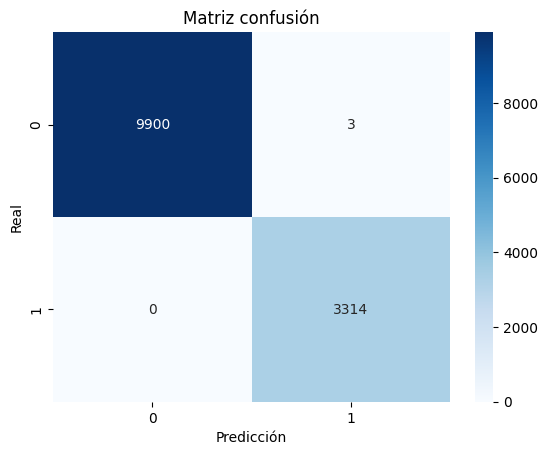

In [36]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz confusión')

Podemos observar que el modelo ha logrado una predicción casi perfecta. Esto indica que el modelo es capaz de predecir si una zona tiene un consumo excesivo de agua. Esto puede deberse a que el dataset es pequeño y ademas la columna de output fue generada a partir de las demas columnas con condiciones. Probablemente el modelo se pueda mejorar con un dataset mas grande y con mas variabilidad en los datos.